In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import glob
import copy
from models.fourier_nn import FourierNet
from floorplans.lidar.lidar import ClippedLidar2D, Lidar2D, RandomPoseLidarDataset, TrajectoryLidarDataset, OnlineTrajectoryLidarDataset

torch.set_default_tensor_type(torch.DoubleTensor)

In [3]:
data_dir = "../floorplans/32_data"

waypoint_dir = os.path.join(data_dir, "some_overlap")
img_path = os.path.join(data_dir, "floor_img.png")

# Data parameters
num_beams = 20
beam_samps = 12
beam_length = 0.2
spline_res = 120
samp_distribution_factor = 1.0
collision_samps = 20
fine_samps = 3
num_scans_in_window = 50
lidar = Lidar2D(img_path, num_beams, beam_length, beam_samps, 
    samp_distribution_factor, collision_samps, fine_samps,
    border_width=30)
#lidar = ClippedLidar2D(img_path, num_beams, beam_length, beam_samps,
#    border_width=30)

datasets = []
for name in glob.glob1(waypoint_dir, "*.npy"):
    waypoints = np.load(os.path.join(waypoint_dir, name))
    ds = OnlineTrajectoryLidarDataset(lidar, waypoints, 
        spline_res, num_scans_in_window)
    #ds = RandomPoseLidarDataset(lidar, 6000)
    print(name, " : ", len(ds), " scan points")
    datasets.append(ds)

# Concatenate the entire dataset
#cent_ds = torch.utils.data.ConcatDataset(datasets)
num_validation_scans = 500
valset = RandomPoseLidarDataset(lidar, num_validation_scans)

5.npy  :  2256000  scan points
4.npy  :  2160000  scan points
2.npy  :  2160000  scan points
6.npy  :  2400000  scan points
7.npy  :  2304000  scan points
3.npy  :  2160000  scan points
1.npy  :  1968000  scan points


In [4]:
if torch.cuda.is_available(): 
    device = torch.device("cuda")
else: 
    device = torch.device("cpu")

# Setup model and centralized optimizer
model = FourierNet([2, 86, 32, 32, 32, 1], scale=0.05).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.005)

KeyboardInterrupt: 

In [ ]:
#batch_size = 10000


loss = torch.nn.BCELoss()
val_loader = torch.utils.data.DataLoader(valset, batch_size=10000)

N = 7
batch_size = 8000
dloaders = []
diters = []
for i in range(N):
    dl = torch.utils.data.DataLoader(datasets[i], batch_size=batch_size)
    dloaders.append(dl)
    diters.append(iter(dl))

epoch_tracker = torch.zeros(N)
current_epoch = 1
epochs = 4

while current_epoch <= 8:
    locs = []
    dens = []
    for i in range(N):
        try:
            batch = next(diters[i])
        except StopIteration:
            epoch_tracker[i] += 1
            diters[i] = iter(dloaders[i])
            batch = next(diters[i])
        locs.append(batch[0].to(device))
        dens.append(batch[1].to(device))
        
    x = torch.cat(locs, axis=0)
    y = torch.cat(dens, axis=0)
        
    opt.zero_grad()
    pd = model.forward(x).squeeze()
    l = loss(pd, y)
    l.backward()
    opt.step()
    
    if torch.sum(epoch_tracker > current_epoch) >= N:
        current_epoch += 1
        print("-------------------------------")
        print("Epochs: ", epoch_tracker)
        with torch.no_grad():
            vloss = 0.0
            for batch in val_loader:
                x, y = batch[0].to(device), batch[1].to(device)
                pd = model.forward(x).squeeze()
                vloss += loss(pd, y).data
        print("Valid loss: ", vloss)

IndexError: index 1132606 is out of bounds for dimension 0 with size 1130973

In [ ]:
print(datasets[1].scan_size * 25)


6000


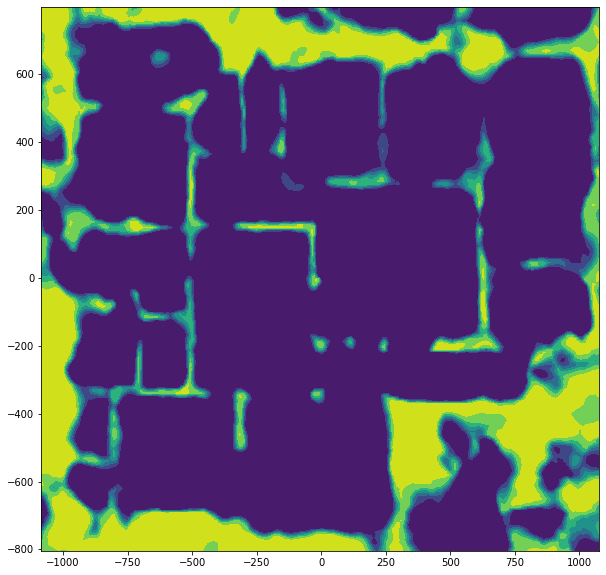

In [ ]:
X, Y = torch.meshgrid(torch.Tensor(lidar.xs), torch.Tensor(lidar.ys))
xlocs = X[::8, ::8].reshape(-1, 1)
ylocs = Y[::8, ::8].reshape(-1, 1)
mesh_inputs = torch.hstack((xlocs, ylocs))
mesh_inputs = mesh_inputs.to(device)

with torch.no_grad():
    mesh_dense = model.forward(mesh_inputs)

(fig, ax) = plt.subplots(figsize=(10, 10))
ax.tricontourf(xlocs.squeeze(), ylocs.squeeze(), mesh_dense.squeeze().cpu())